<img src="../../images/QISKit.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Quantum Teleportation and Superdense Coding*_ 


The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Anna Phan, Jay Gambetta

## Introduction

In [superposition and entanglement](superposition_and_entanglement.ipynb), we introduced you to the quantum concept of entanglement, in particular, the maximally entangled quantum state $|\psi\rangle = (|00\rangle + |11\rangle)$. In [entanglement revisited](entanglement_revisited.ipynb), we explored this state in detail, running various experiments to compare quantum mechanics to hidden variable models. In this notebook, we will explore how this state can be used in two quantum communication protocols:
* [Teleportation](#teleportation), where a qubit state is transmitted using two classical bits; and
* [Superdense Coding](#superdensecoding), where two classical bits are transmitted using one qubit. 

In [1]:
import sys
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except:
    qx_config = {
        "APItoken":"YOUR_TOKEN_HERE",
        "url":"https://quantumexperience.ng.bluemix.net/api"}

In [2]:
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pprint import pprint

# importing the QISKit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import QuantumProgram

# import basic plot tools
from qiskit.tools.visualization import plot_histogram, circuit_drawer

## _Quantum Teleportation_<a id='teleportation'></a>

Quantum teleportation is a protocol to transmit quantum states from one location to another, assisted by a previously shared entangled state and a classical communication channel. It was devised by Charles H. Bennett (IBM), Gilles Brassard, Claude Crépeau, Richard Jozsa, Asher Peres, and William K. Wootters in [1993](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.1895). It was first demonstrated with photons in [1997](http://www.nature.com/nature/journal/v390/n6660/abs/390575a0.html), and has since been realised in [atoms](http://www.nature.com/nphys/journal/v9/n7/abs/nphys2631.html), [ions](http://www.nature.com/nature/journal/v429/n6993/full/nature02570.html, http://www.nature.com/nature/journal/v429/n6993/full/nature02608.html), [electrons](http://science.sciencemag.org/content/345/6196/532) and [superconducting circuits](http://www.nature.com/nature/journal/v500/n7462/full/nature12422.html). The [record](http://www.nature.com/nature/journal/v489/n7415/full/nature11472.html) distance for quantum teleportation is 143 km via satellite, set in 2012.

<img src="../../images/teleportation.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="600 px" align="center">

As illustrated above, the protocol starts out with a shared entangled state between the sender (Alice) and the receiver (Bob):
$$|\psi\rangle_{AB} = \frac{1}{\sqrt{2}}(|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B)$$
The first qubit, denoted by subscript $A$, belongs to Alice, and the second qubit, $B$, belongs to Bob.

Alice has a quantum state that she wants to convey to Bob:
$$|\psi\rangle_{C} = \alpha|0\rangle_C + \beta|1\rangle_C$$

At this point, Alice has two quantum states ($C$, the one she wants to teleport, and $A$, one of the entangled pair), and Bob has one quantum state. The total state of the system is given by:
$$|\psi\rangle_{AB} \otimes |\psi\rangle_C = \frac{1}{\sqrt{2}}(|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B) \otimes (\alpha|0_C\rangle + \beta|1_C\rangle)$$
or, in the Bell basis:
$$|\psi\rangle_{AB} \otimes |\psi\rangle_C = \frac{1}{2}[
|\Phi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B) + 
|\Phi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B) + \\
|\Psi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B) + 
|\Psi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B) ]$$
where:
$$|0\rangle \otimes |0\rangle = \frac{1}{\sqrt{2}}(|\Phi^+\rangle + |\Phi^-\rangle), 
|0\rangle \otimes |1\rangle = \frac{1}{\sqrt{2}}(|\Psi^+\rangle + |\Psi^-\rangle)\\
|1\rangle \otimes |0\rangle = \frac{1}{\sqrt{2}}(|\Psi^+\rangle - |\Psi^-\rangle), 
|1\rangle \otimes |1\rangle = \frac{1}{\sqrt{2}}(|\Phi^+\rangle - |\Phi^-\rangle).$$

Alice now measures her two quantum states, $A$ and $C$, in the Bell basis. This will collapse the three state system into the one of the following four states with equal probability, with the corresponding measurement outcomes:
- **00**: $|\Phi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B)$
- **01**: $|\Phi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B)$
- **10**: $|\Psi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B)$ 
- **11**: $|\Psi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B)$

Alice now sends the results of her measurements to Bob. Using this information, he performs one of the following transformations on his quantum state to transform it to the desired state $\alpha|0\rangle_B - \beta|1\rangle_B$:
- If he receives **00**, he applies $I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$
- If he receives **01**, he applies $X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$ 
- If he receives **10**, he applies $Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$
- If he receives **11**, he applies $XZ = \begin{pmatrix} 0 & -1 \\ 1 & 0 \end{pmatrix}$ 

Transmission (teleportation) of $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ is thus achieved. 

Recall from [superposition and entanglement](superposition_and_entanglement.ipynb) and [entanglement revisited](entanglement_revisited.ipynb) that the steps to make the shared entangled state $|\psi\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$ are:
1. Start with an initial state $|0_A 0_B\rangle$
2. Apply $H = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$ on $q_A$ 
3. Then a $CNOT = \begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1\\0& 0& 1 & 0\\0 & 1 & 0 & 0 \end{pmatrix}$ from $q_A$ to $q_B$

With $q_A = q_1$ and $q_B = q_2$, this looks like:

In [3]:
# Creating registers
tq = QuantumRegister('tq', 3)
tc0 = ClassicalRegister('tc0', 1)
tc1 = ClassicalRegister('tc1', 1)
tc2 = ClassicalRegister('tc2', 1)

# Quantum circuit to make the shared entangled state 
teleport = QuantumCircuit(tq, tc0,tc1,tc2)
teleport.h(tq[1])
teleport.cx(tq[1], tq[2])

Alice then prepares her quantum state to be teleported, $|\psi\rangle_{C} = \alpha|0\rangle_C + \beta|1\rangle_C$. In this experiment, $\alpha = \cos(\frac{\theta}{2})$ and $\beta = \sin(\frac{\theta}{2})$ where $\theta = \frac{\pi}{4}$. This state can be created by applying a rotation around the y axis:
$R_y(\theta)$ on $q_C$

With $q_C = q_0$, this looks like:

In [4]:
teleport.ry(np.pi/4,tq[0])

Alice now applies $CNOT$ to her two quantum states $q_A(q_1)$ and $q_C(q_0)$, followed by an $H$, to entangle them and project them into the Bell basis:

In [5]:
teleport.cx(tq[0], tq[1])
teleport.h(tq[0])
teleport.barrier()

She now measures her two quantum states $q_A(q_1)$ and $q_C(q_0)$:

In [6]:
teleport.measure(tq[0], tc0[0])
teleport.measure(tq[1], tc1[0])



Depending on the results of these measurements, Bob has to apply an $X$ or $Z$, or both, to his quantum state $q_B(q_2)$:

In [7]:
teleport.z(tq[2]).c_if(tc0, 1)
teleport.x(tq[2]).c_if(tc1, 1)

His state is now the same as the state Alice prepared earlier, which can be verified by measurement:

In [8]:
teleport.measure(tq[2], tc2[0])

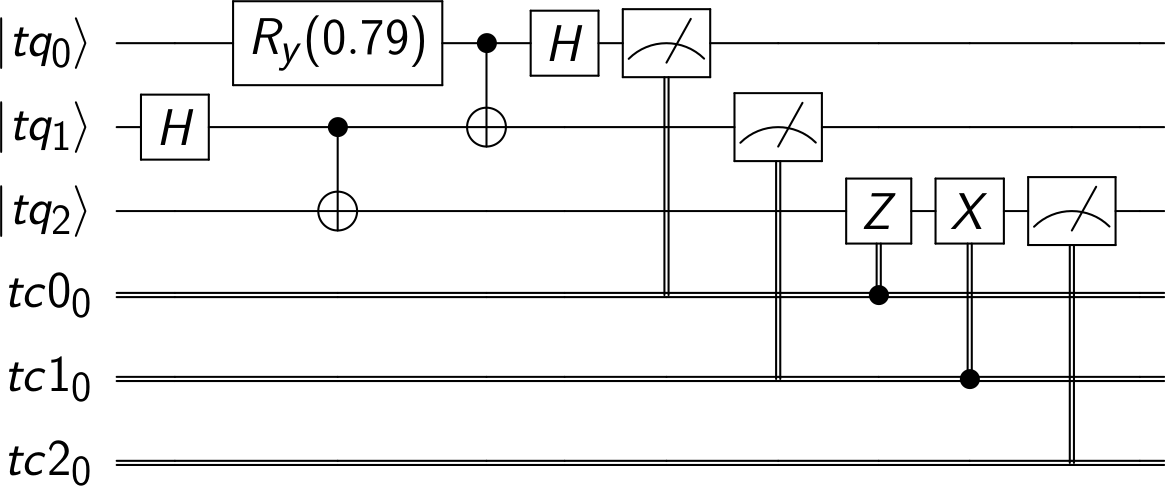

In [9]:
circuit_drawer(teleport)

Let's now create and execute the quantum circuits on the simulator (so we don't have to wait in queue for a device) and plot the results:

In [10]:
circuits = ['teleport']

backend = 'local_qasm_simulator' # run on simulator so we don't have to wait in the device queue
shots = 10000 # the number of shots in the experiment 
Q_program = QuantumProgram()
Q_program.add_circuit('teleport',teleport)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)

We must manipulate the data to understand the results better, first only plotting the results of Alice's measurement:  

Note each classical register is seperated by a space, and the order is c2 c1 c0.

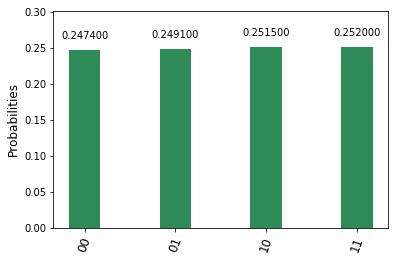

In [11]:
data = result.get_counts('teleport')
alice = {}
alice['00'] = data['0 0 0'] + data['1 0 0']
alice['10'] = data['0 1 0'] + data['1 1 0']
alice['01'] = data['0 0 1'] + data['1 0 1']
alice['11'] = data['0 1 1'] + data['1 1 1']
plot_histogram(alice)

As expected, the probabilities are roughly equal.  

Now, manipulate the data to plot the result of Bob's measurement:

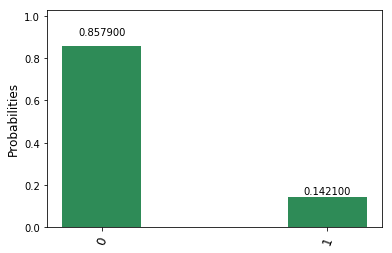

In [12]:
bob = {}
bob['0'] = data['0 0 0'] + data['0 1 0'] +  data['0 0 1'] + data['0 1 1']
bob['1'] = data['1 0 0'] + data['1 1 0'] +  data['1 0 1'] + data['1 1 1']
plot_histogram(bob)

As expected, $|\alpha|^2 = |\cos(\frac{\pi}{8})|^2 \approx 0.854$ (the probability of measuring 0) and $|\beta|^2 = |\sin(\frac{\pi}{8})|^2 \approx 0.146$ (the probability of measuring 1).

## _Quantum Superdense Coding_<a id='superdensecoding'></a>

Quantum superdense coding is the dual protocol of quantum teleportation, whereby two classical bits of information are transmitted using only one qubit and a previously shared entangled state. It was devised by Charles Bennett (IBM) and Stephen Wiesner in [1992](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.69.2881). 

<img src="../../images/superdensecoding.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="600 px" align="center">

As illustrated above, and as in quantum teleportation, the protocol starts out with a shared entangled state between the sender (Alice) and the receiver (Bob):
$$|\psi\rangle_{AB} = \frac{1}{\sqrt{2}}(|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B)$$
The first qubit, denoted by subscript $A$, belongs to Alice, and the second qubit, $B$, belongs to Bob.

Alice wants to send a two bit message to Bob, 00, 01, 10, or 11.  She performs a single qubit operation on her qubit which transforms the entangled state according to which message she wants to send:
- For a message of **00**: Alice applies $I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$. The resultant state would be $|\psi_{00}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$
- For a message of **01**: Alice applies $X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$. The resultant state would be $|\psi_{01}\rangle = \frac{1}{\sqrt{2}}(|1_A 0_B\rangle + |0_A 1_B\rangle)$  
- For a message of **10**: Alice applies $Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$. The resultant state would be $|\psi_{10}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 1_B\rangle)$ 
- For a message of **11**: Alice applies $XZ = \begin{pmatrix} 0 & -1 \\ 1 & 0 \end{pmatrix}$. The resultant state would be $|\psi_{11}\rangle = \frac{1}{\sqrt{2}}(- |1_A 0_B\rangle + |0_A 1_B\rangle $

The key to superdense coding is that these four states, $|\psi_{00}\rangle, |\psi_{01}\rangle, |\psi_{10}\rangle, |\psi_{11}\rangle$ (otherwise known as the [Bell states](https://en.wikipedia.org/wiki/Bell_state)), are orthonormal and are hence distinguishable by a quantum measurement.

In [13]:
# Creating registers
sdq = QuantumRegister("sdq", 2)
sdc = ClassicalRegister("sdc", 2)

# Quantum circuit to make the shared entangled state 
superdense = QuantumCircuit(sdq, sdc)
superdense.h(sdq[0])
superdense.cx(sdq[0], sdq[1])

Alice now needs to decide what two bit message she wants to transmit to Bob, ($00$, $01$, $10$, or $11$), and perform the corresponding to transformation ($I$, $X$, $Z$ or $XZ$ respectively) to her qubit $q_A$ ($q_0$). In this case, she encodes $11$:

In [14]:
# For 00, do nothing

# For 01, apply $X$
#shared.x(q[0])

# For 01, apply $Z$
#shared.z(q[0])

# For 11, apply $XZ$
superdense.z(sdq[0]) 
superdense.x(sdq[0])
superdense.barrier()

Bob now needs to 'decode' the message that Alice sent him. Since measurement in QISKit is only possible in the standard computational basis, he does this by:
1. Applying a $CNOT$ from $q_A$ to $q_B$
2. Then a $H$ on $q_A$ 
3. And measuring $q_A$ and $q_B$

Recalling that $q_A = q_0$ and $q_B = q_1$, this looks like:

In [15]:
superdense.cx(sdq[0], sdq[1])
superdense.h(sdq[0])
superdense.measure(sdq[0], sdc[0])
superdense.measure(sdq[1], sdc[1])

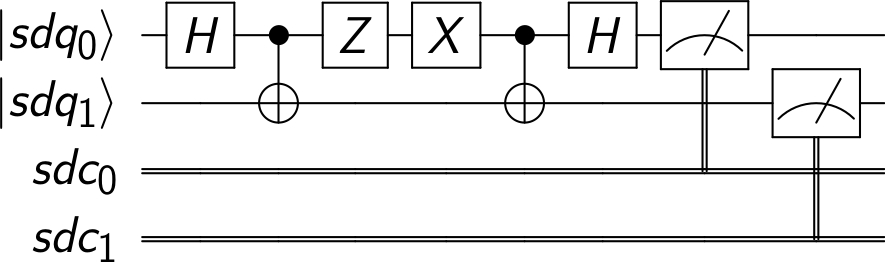

In [16]:
circuit_drawer(superdense)

Let's now create, execute the quantum circuits, and plot the results:

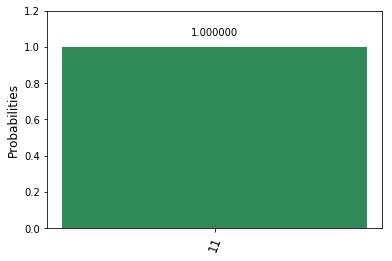

In [17]:
circuits = ["superdense"]

backend = 'local_qasm_simulator' # run on simulator so we don't have to wait in the device queue
shots = 1000 # the number of shots in the experiment 
Q_program.add_circuit('superdense',superdense)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)

plot_histogram(result.get_counts("superdense"))

The state with the highest probability should match the message that Alice encoded earlier ($11$). Mathematically:
- For a message of **00**: Bob received $|\psi_{00}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 0_B\rangle + |1_A 0_B\rangle)$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|0_B\rangle + (|0_A\rangle - |1_A\rangle)|0_B\rangle] = |0_A 0_B\rangle$ 
- For a message of **01**: Bob received $|\psi_{01}\rangle = \frac{1}{\sqrt{2}}(|1_A 0_B\rangle + |0_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 1_B\rangle)+ |1_A 1_B\rangle$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|1_B\rangle + (|0_A\rangle - |1_A\rangle)|1_B\rangle + (|0_A\rangle + |1_A\rangle)|1_B\rangle] = |0_A 1_B\rangle$ 
- For a message of **10**: Bob received $|\psi_{10}\rangle = \frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 1_B\rangle)$. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 0_B\rangle - |1_A 0_B\rangle)$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|0_B\rangle - (|0_A\rangle - |1_A\rangle)|0_B\rangle] = |1_A 0_B\rangle$ 
- For a message of **11**: Bob received $|\psi_{11}\rangle = \frac{1}{\sqrt{2}}(- |1_A 0_B\rangle + |0_A 1_B\rangle $. Applying $CNOT$ gives: $\frac{1}{\sqrt{2}}(|0_A 1_B\rangle - |1_A 1_B\rangle)$. Applying $H$ on $q_A$ results in: $\frac{1}{\sqrt{2}}\frac{1}{\sqrt{2}}[(|0_A\rangle + |1_A\rangle)|1_B\rangle - (|0_A\rangle - |1_A\rangle)|1_B\rangle] = |1_A 1_B\rangle$ 

In [1]:
%run "../../version.ipynb"

Package,Version
QISKit,0.4.10
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
